<a href="https://colab.research.google.com/github/ra4ola/APA-Assigment2/blob/main/Parte%201/Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
from torch.nn.modules.flatten import Flatten
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from google.colab import drive
import torch.nn.functional as F

In [23]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definição de Variáveis

In [24]:
PATH = '/content/drive/MyDrive/APA/Assigment2/Parte3'

In [25]:
image_size = 28
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

## Outras

### Funções de Construção das String para os Caminhos

In [26]:
def ModelDirStr(modelName,path = PATH):
  return f"{path}/{modelName}"
def pathModelStr(modelName,epoch, path = PATH):
  return f"{ModelDirStr(modelName,path)}/{modelName}_epoch={epoch}"

### Função Display Images

In [27]:
def reconstruction_images_plot(model,test_loader):
  with torch.no_grad():
    for data in test_loader:
      inputs, _ = data
      inputs = inputs.to(device)

      outputs = model(inputs)

      n = 10
      plt.figure(figsize=(20, 4))
      for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(inputs[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

      plt.show()
      break

### Função de Implementação das Perdas

In [28]:
def evaluate_training(model,training_loader, loss_fn, num_epochs,modelName, path = PATH):
    all_losses = []
    all_ssim = []
    all_psnr = []

    for epoch in range(num_epochs):
        # Load the model
        model_path = pathModelStr(
            modelName = modelName,
            path = path,
            epoch = epoch
            )
        model = torch.load(model_path)
        model.to(device)
        model.eval()

        running_loss = 0.0
        running_psnr = 0.0
        runningn_ssim = 0.0
        with torch.no_grad():
            for batch in training_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, inputs)

                psnr = 10 * torch.log10(1 / loss)

                running_loss += loss.item()
                running_psnr += psnr.item()

        running_loss /= len(training_loader)
        running_psnr /= len(training_loader)


        all_losses.append(running_loss)
        all_psnr.append(running_psnr)

        print(f'Epoch {epoch}: Validation Loss: {running_loss:.4f}, PSNR: {running_psnr:.4f}')

    return all_losses, all_psnr,all_ssim


In [42]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b', label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'r', label='Accuracy')
    plt.title('PSNR')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [30]:
def VAETrain(model,criterion,optimizer,train_loader,epochs,modelName,scheduler=None, path = PATH):
  os.makedirs(ModelDirStr(modelName= modelName,path= path), exist_ok=True)
  for epoch in range(epochs):
    for data in train_loader:
      inputs, _ = data
      inputs = inputs.to(device)
      optimizer.zero_grad()
      outputs, mean, log_var = model(inputs)

      reconstruction_loss = criterion(outputs, inputs)
      kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
      loss = reconstruction_loss + kld_loss

      loss.backward()
      optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    if scheduler is not None:
      scheduler.step()

    torch.save(model, pathModelStr(modelName= modelName,path = path, epoch = epoch))

## *AE*




### Função de Treino *AE*


In [31]:
def AEtrain(model,criterion,optimizer,train_loader,epochs,modelName,scheduler=None, path = PATH):
  os.makedirs(ModelDirStr(modelName= modelName,path= path), exist_ok=True)
  for epoch in range(epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    if scheduler is not None:
      scheduler.step()

    torch.save(model, pathModelStr(modelName= modelName,path = path, epoch = epoch))



## *VAE*

# Importação do DataSet

In [32]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Modelos


## *AE*

In [33]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder_conv = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        self.decoder_conv = nn.Sequential(

         nn.ConvTranspose2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(128),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(64),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(32),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(8),
         nn.ELU(),

         nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample
         nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(1),
         nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.decoder_conv(x)
        return x

## *VAE*


### Função de Treino *VAE*

#### Kullback-Leibler Divergence (KLD) Loss:

$$ D_{KL} = -\frac{1}{2} \sum_{i} (1 - \mu_{i}^{2} + \log(\sigma_{i}^{2}) - e^{\log(\sigma_{i}^{2})}) $$


In [34]:
class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()
      self.encoder_conv = nn.Sequential(
          nn.Conv2d(1, 8, 3, 2, 1),
          nn.BatchNorm2d(8),
          nn.ELU(inplace=True),

          nn.Conv2d(8, 32, 3, 1, 1),
          nn.BatchNorm2d(32),
          nn.ELU(inplace=True),

          nn.Conv2d(32, 64, 3, 1, 1),
          nn.BatchNorm2d(64),
          nn.ELU(inplace=True),

          nn.Conv2d(64, 128, 3, 1, 1),
          nn.BatchNorm2d(128),
          nn.ELU(inplace=True),
        )

      self.mean_layer = nn.Linear(128 * (image_size // 2) ** 2, 16)

      self.logvar_layer = nn.Linear(128 * (image_size // 2) ** 2, 16)

      self.decoder_conv = nn.Sequential(

          nn.ConvTranspose2d(16, 128, 3, 1, 1),
          nn.BatchNorm2d(128),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(128, 64, 3, 1, 1),
          nn.BatchNorm2d(64),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(64, 32, 3, 1, 1),
          nn.BatchNorm2d(32),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(32, 8, 3, 1, 1),
          nn.BatchNorm2d(8),
          nn.ELU(inplace=True),

          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.ConvTranspose2d(8, 1, 3, 1, 1),
          nn.BatchNorm2d(1),
          nn.Sigmoid()
        )

    def forward(self, x):
      x = add_noise()
      x = self.encoder_conv(x)
      x = x.view(x.size(0), -1)
      mean, logvar = self.mean_layer(x), self.logvar_layer(x)
      epsilon = torch.randn_like(torch.exp(0.5 * logvar)).to(device)
      x = mean + logvar*epsilon
      x = self.decoder_conv(x.view(x.size(0), 16, (image_size // 2), (image_size // 2)))
      return x, mean, logvar



## DAE

### Função para adicionar Noise

In [35]:
def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * torch.randn_like(data)
    return torch.clamp(noisy_data, 0., 1.)


In [36]:
class DAE(nn.Module):
    def __init__(self):
      super(DAE, self).__init__()
      self.encoder = AE()

    def forward(self, x):
      x = add_noise(x)
      x = encoder(x)
      return x

# Implementação dos Modelos

## Inicialização do Modelo

In [44]:
epochs = 3
ae = AE().to(device)
vae = VAE().to(device)
dae = DAE().to(device)

criterion = nn.MSELoss()


optimizerAE = optim.Adam(ae.parameters(), lr = lr)
optimizerVAE = optim.Adam(vae.parameters(), lr = lr)
optimizerDAE = optim.Adam(dae.parameters(), lr = lr)

## AE Treino

In [49]:
AEtrain(
    model = ae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "AE",
    scheduler=None,
    path = PATH
  )

Epoch [1/3], Loss: 1.0225
Epoch [2/3], Loss: 0.9472
Epoch [3/3], Loss: 0.9225


In [50]:
loss,acc =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "AE",
    path = PATH
    )

Epoch 0: Validation Loss: 1.0000, PSNR: -0.00011408584486101884
Epoch 1: Validation Loss: 0.9561, PSNR: 0.19490053744585528
Epoch 2: Validation Loss: 0.9249, PSNR: 0.33933513511472674


ValueError: ignored

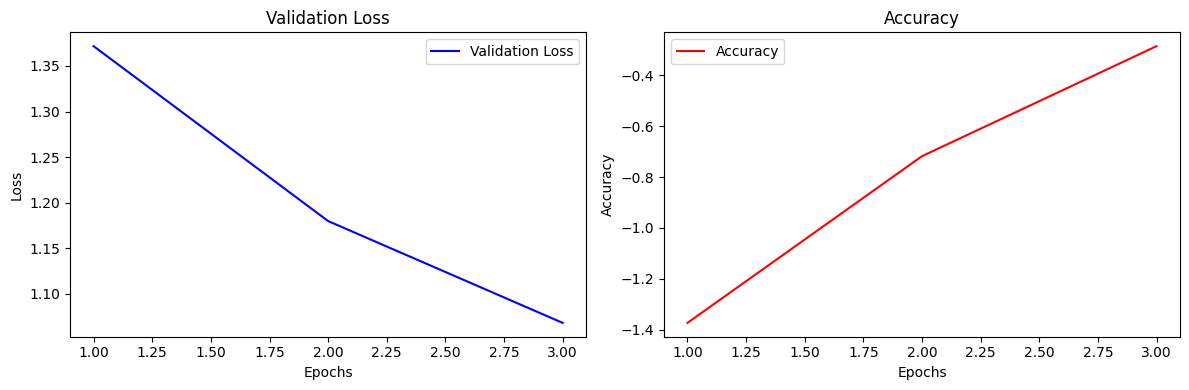

In [40]:
plot_loss_accuracy(losses = loss,accuracies=acc)

## DAE Treino

In [47]:
AEtrain(
    model = dae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "DAE",
    scheduler=None,
    path = PATH
  )

NameError: ignored

In [ ]:
loss,acc =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "AE",
    path = PATH
  )

In [ ]:
plot_loss_accuracy(losses = loss,accuracies=acc)

## VAE Treino

In [ ]:
VAEtrain(
    model = vae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "VAE",
    scheduler=None,
    path = PATH
  )

In [ ]:
loss,acc =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "AE",
    path = PATH
  )

In [ ]:
plot_loss_accuracy(losses = loss,accuracies=acc)

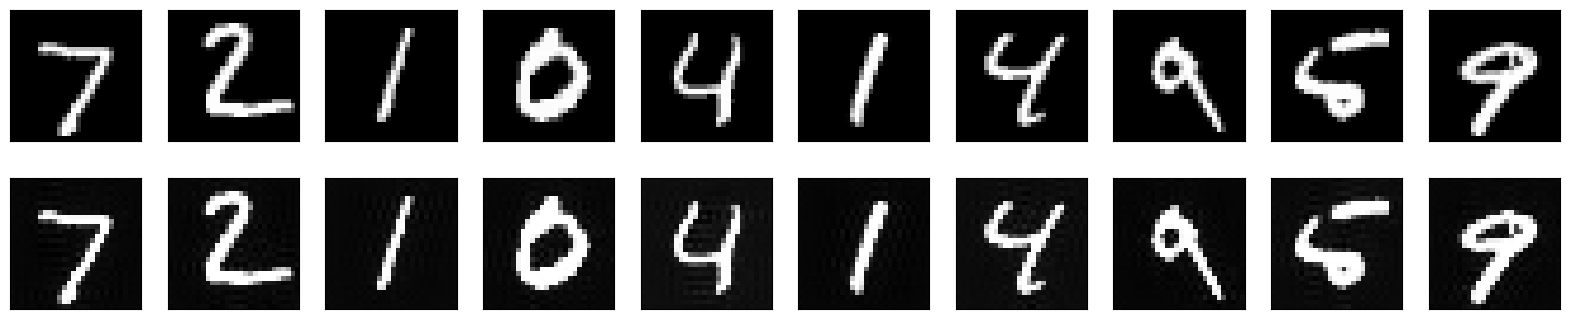

In [43]:
reconstruction_images_plot(ae,test_loader)